In [1]:
!pip install git+https://github.com/fastai/fastai.git &> /dev/null

## 00:30:48 - Multi-label classification

* More than one or more labels per image.

## 00:32:01 - Question: is dropping floating point number precision have impact on final loss?

* Sometimes it makes it better.
  * Doing some random, that creates more uncertainty.
  * Usually doesn't make the difference either way.
  
## 00:33:53 - Exploring Pascal dataset.

* Pascal is a famous dataset with more than one kind of classified object per image.

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

* Comes with a CSV which includes the labels for each image.

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


* List of categories in each image, a space delimited string (eg `horse person`)

## 00:34:30 - Pandas

* The pd above stands for Pandas: important library for data processing.
* Main class is `DataFrame`, which is table of rows and columns.
* Can access rows and columns with `iloc` property.
* Getting column 0:

In [4]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

* Getting row 0:

In [5]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

* Can also get column by name:

In [6]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

* Can create a DataFrame from a dict:

In [7]:
tmp_df = pd.DataFrame({'a': [1, 2], 'b': [3,4]})
tmp_df

,a,b
0,1,3
1,2,4


* Then create a new column by adding other columns:

In [8]:
tmp_df['c'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


* Book recommendation: [Python for Data Analysis](https://www.booktopia.com.au/python-for-data-analysis-wes-mckinney/book/9781491957660.html?source=pla&gclid=CjwKCAjw87SHBhBiEiwAukSeUV_4QpUkHIAGdeAMJTyNCPV8-QsCvDiHyBun8i8PFM_grov0o1ITVRoCHlkQAvD_BwE) by Wes Mckinney.

## 00:37:10 - Review Dataset and DataLoader

* We want to create DataBlock that we can train from.
* Reminder about `Dataset` and `DataLoader`
  * `Dataset` - anything you can index into:

In [9]:
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

   * `DataLoader` - an interator that gives you a stream of mini batches with independent and dependent vars

In [10]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([18,  8, 25, 23, 19, 16,  3,  6]),
 ('s', 'i', 'z', 'x', 't', 'q', 'd', 'g'))

In [11]:
list(zip(b[0], b[1]))

[(tensor(18), 's'),
 (tensor(8), 'i'),
 (tensor(25), 'z'),
 (tensor(23), 'x'),
 (tensor(19), 't'),
 (tensor(16), 'q'),
 (tensor(3), 'd'),
 (tensor(6), 'g')]

* Can use `*` which inserts each element of list as arg in function.

In [12]:
list(zip(*b))

[(tensor(18), 's'),
 (tensor(8), 'i'),
 (tensor(25), 'z'),
 (tensor(23), 'x'),
 (tensor(19), 't'),
 (tensor(16), 'q'),
 (tensor(3), 'd'),
 (tensor(6), 'g')]

## 00:40:04 - Datasets and DataLoaders

* `Datasets` is an object that has a training and validation dataset.

* Sometimes easiest to start by creating and testing `Datasets`:

In [13]:
a = list(string.ascii_lowercase)
a[0], len(a)

('a', 26)

In [14]:
dss = Datasets(a)
dss[0]

('a',)

* Can use functions to create independent and dependent variables:
  * (for example, open image and create lable from filename).

In [15]:
def f1(o): return o+'a'
def f2(o): return o+'b'

In [16]:
dss = Datasets(a, [[f1]])
dss[0]

('aa',)

In [17]:
dss = Datasets(a, [[f1, f2]])
dss[0]

('aab',)

In [18]:
dss = Datasets(a, [[f1], [f2]])
dss[0]

('aa', 'ab')

* Can then create a `DataLoaders` instance:

In [19]:
dls = DataLoaders.from_dsets(dss, batch_size=4)

In [20]:
first(dls.train)

(('ia', 'da', 'ca', 'ja'), ('ib', 'db', 'cb', 'jb'))

## 00:43:23 - DataBlock

* Instead of creating `DataLoaders` from scratch, can use a `DataBlock`:

In [21]:
dblock = DataBlock()

In [22]:
dsets = dblock.datasets(df)

In [23]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [24]:
x, y = dsets.train[0]
x, y

(fname                   006958.jpg
 labels      dog person diningtable
 is_valid                     False
 Name: 3512, dtype: object,
 fname                   006958.jpg
 labels      dog person diningtable
 is_valid                     False
 Name: 3512, dtype: object)

* It's returning the same thing in for both variables, as that's the deault behaviour.
* You can pass `get_x` and `get_y` functions:

In [25]:
x['fname']

'006958.jpg'

In [26]:
dblock = DataBlock(
    get_x=lambda r: r['fname'],
    get_y=lambda r: r['labels']
)
dsets = dblock.datasets(df)
dsets.train[0]

('005888.jpg', 'dog')

* To save (serialize) `DataBlock`, you can't use lambdas.
* Next, we can add the full path to the image, and split on the label name:

In [27]:
Path.BASE_PATH = path

In [28]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/001680.jpg'), ['dog'])

* Since we want the image opened as an image, `blocks` argument lets you say what sort of "block" you want for each item in tuple.
* In the example below, we use `MultiCategoryBlock` which expects a list of strings:

In [29]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=375x500,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

## 00:48:36 - One-Hot Encoding

* The labels there are [[One-Hot Encoded]]
  * Each position corresponds to a possible label.
  * If the label isn't in the image, it's 0. If it is 1.
* We can take a look at the first label, and see what it is:

In [30]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
idxs, dsets.train.vocab[idxs]

(TensorMultiCategory([ 4, 11, 14]), (#3) ['bottle','dog','person'])

## 00:50:44 - Question: shouldn't tensor be of integers?

* Conceptually it's a tensor of integers, but for the purpose of floating point calculations in cross entropy, we just make it a float.

## 00:51:30 - splitter function

* The `DataBlock` uses a random split by default.
* This dataset tells you what's in the validation set: usually a good idea to use the dataset's validation, so you can compare results.
* The `splitter` function can be used to return the idxes in the train and validation set:

In [31]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblck = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]))

## 00:52:39 - Question: why don't we use 8-bit precision?

* It's too flat and bumpy - hard to get good gradients.
  * Sometimes they do a thing called "Quantization" to allow a model to do inference much faster.

## 00:53:54 - Finish DataBlock

* Now we add `item_tfms` to allow collation into DataLoader:

In [32]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35))

* Then `dataloaders` to get a DataLoader back:

In [33]:
dls = dblock.dataloaders(df)

* And summary to ensure it all worked:

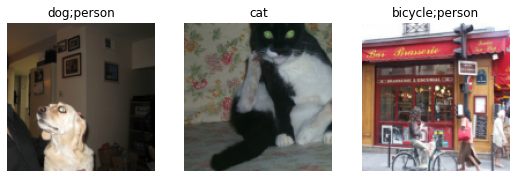

In [34]:
dls.show_batch(nrows=1, ncols=3)

## 00:54:48 - Binary cross entropy

* To start', we'll grab a learner using the dls above:

In [35]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


* Get one batch of predictions:

In [36]:
x, y = dls.train.one_batch()

In [37]:
activs = learn.model.cuda()(x)

* Examine one set of activations for an item in the batch:

In [38]:
activs[0]

tensor([ 4.0968, -1.0870,  0.5517, -0.9677,  0.7336, -0.6855, -2.5957, -0.5128,
         1.8058, -0.1456,  2.2515, -2.8793, -0.2660, -0.4388,  1.7154, -2.8521,
         0.2223, -1.6583, -0.3429,  1.3525], device='cuda:0',
       grad_fn=<SelectBackward>)

## 00:56:10 - Question: Is DataBlock API compatible with libraries like Dask?

* DataBlock API allows you to pass anything that's indexable, including Dask.

## 00:57:20 - Question: what path should the images be in?

* Anywhere. You specify an absolute path in the `get_x` function.

## 00:58:49 - Binary cross entropy cont

* The activations above aren't between 0 and 1, but you can use the [[Sigmoid]] function for that:

In [39]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).log().mean()

* Not that `log` is applied here again so the training is "better behaved".
  * The function works on a single output or multiple.
* In PyTorch, the function is `F.binary_cross_entropy`, or the module version is `nn.BCELoss`
* The above loss functions don't use initial Sigmoid. Use `F.binary_cross_entropy_with_logits` or `nn.BCEWithLogitsLoss` if providing logits.
* For single-label datasets like MNIST or Pets, `F.nll_loss` (doesn't include Softmax) and `F.cross_entropy` (includes Softmax) are the equivalents.

## 01:03:29 - Multi-label metric

* Previously using error_rate (which is 1-accuracy), but that only works for single label dataset (argmax)
* In multi-label, can't use argmax because could have 0 or more labels.
  * Need to introduce a `threshold` where above considered 1 and below 0.
* In learner, you pass the metric as a function. To change `threshold` can use a function called `partial`:

In [40]:
accuracy_multi_metric = partial(accuracy_multi, thresh=0.2)

In [41]:
learn = cnn_learner(dls, resnet50, metrics=accuracy_multi_metric)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

* Note that we don't need to loss func, as fastai figures it out:

In [42]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [43]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.943449,0.704824,0.231494,00:31
1,0.823522,0.564629,0.289263,00:29
2,0.604577,0.197298,0.834024,00:30
3,0.359946,0.124828,0.940100,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132768,0.118560,0.939841,00:30
1,0.118844,0.106433,0.948586,00:30
2,0.096761,0.100886,0.952012,00:30


## 01:07:13 - Tuning threshold

* One way to find best threshold is to calculate accuracy at a range of thresholds and plot

In [44]:
preds, targs = learn.get_preds()

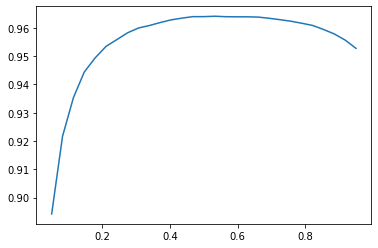

In [45]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

* The fact it's a curve and not a bumpy function, is a good indication we're on right track.

## 01:09:09 - Regression (cont next notebook)